In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import gymnasium as gym
import seaborn as sns

In [5]:
env = gym.make('Blackjack-v1', sab=True)

def blackjack(env, N, gamma, sampleMean, epsilon = 0.1):
    Q = {}
    policy = {}
    
    policy.update({(20, dealer, ace): 0 for dealer in range(1,11) for ace in (True, False)})
    policy.update({(21, dealer, ace): 0 for dealer in range(1,11) for ace in (True, False)})
    
    visits = {}
    
    for _ in range(N):
        state = env.reset()[0]
        episode = []
        while True:
            if np.random.random() < epsilon:
                action = env.action_space.sample()
            else:
                if state not in policy:
                    policy[state] = 1
                action = policy[state]
            nextState, reward, terminated, x, x = env.step(action)
            episode.append((state, action, reward, nextState))
            if terminated:
                break
            state = nextState
        
        G = 0
        episode.reverse()
        for state, action, reward, nextState in episode:
            G = gamma * G + reward
            if state not in visits:
                visits[state] = np.zeros(env.action_space.n)
            visits[state][action] += 1
            
            if sampleMean:
                alpha = 1/visits[state][action]
            else:
                alpha = 0.1
                
            if state not in Q:
                Q[state] = np.zeros(env.action_space.n)
            Q[state][action] = Q[state][action] + alpha * (G - Q[state][action])
            
            if state not in policy:
                policy[state] = 1
            policy[state] = np.argmax(Q[state])
            
    return Q, policy

Q10, Policy10 = blackjack(env, 10000, 1, True)
Q50, Policy50 = blackjack(env, 500000, 1, True)

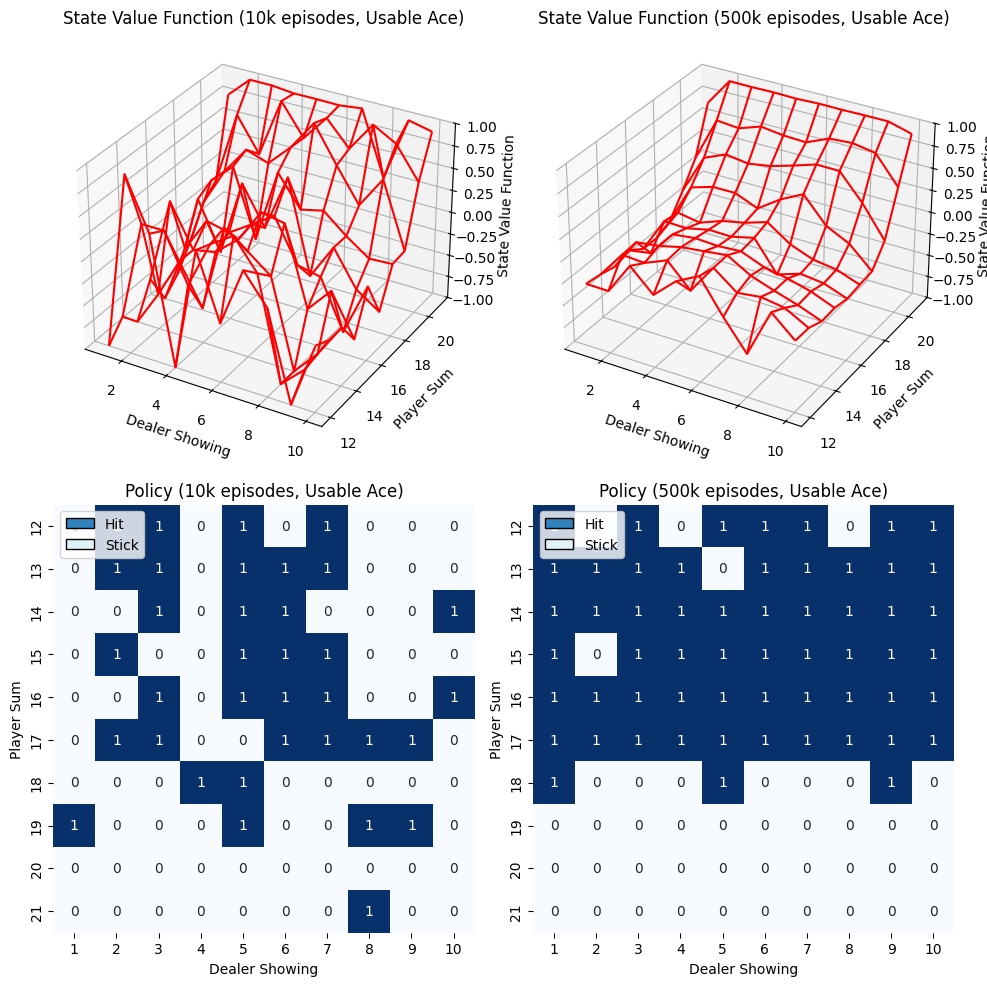

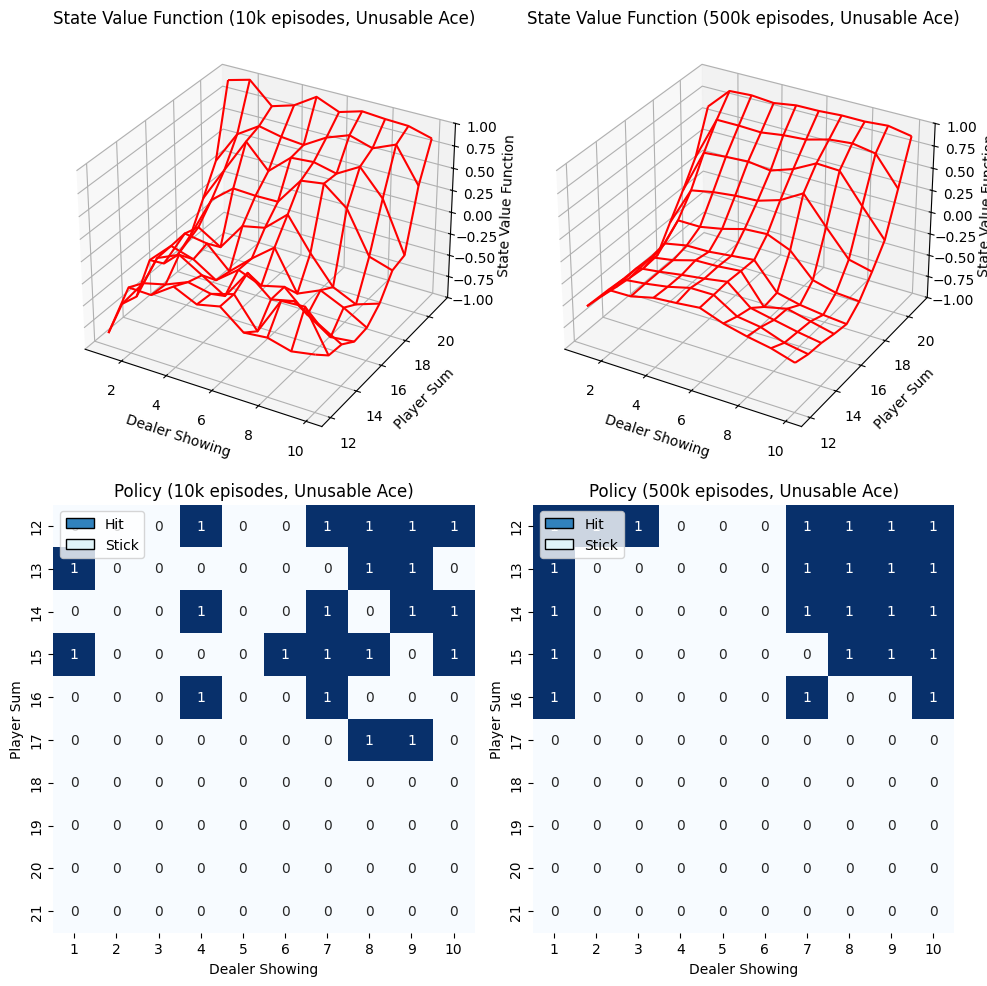

In [6]:
def plot_value_function(Q, title, ax, usable_ace):
    player_sums = np.arange(12, 22)
    dealer_sums = np.arange(1, 11)
    Z = np.zeros((len(player_sums), len(dealer_sums)))

    for i in range(len(player_sums)):
        player_sum = player_sums[i]
        for j in range(len(dealer_sums)):
            dealer_card = dealer_sums[j]
            state = (player_sum, dealer_card, usable_ace)
            if state in Q:
                Z[i, j] = max(Q[state])
            else:
                Z[i, j] = 0

    X, Y = np.meshgrid(dealer_sums, player_sums)
    ax.plot_wireframe(X, Y, Z, color='red')
    ax.set_zlim(-1, 1)
    ax.set_xlabel('Dealer Showing')
    ax.set_ylabel('Player Sum')
    ax.set_zlabel('State Value Function')
    ax.set_title(title)

def plot_policy(Q, title, ax, usable_ace):
    player_sums = np.arange(12, 22)
    dealer_sums = np.arange(1, 11)
    Z = np.zeros((len(player_sums), len(dealer_sums)))

    for i in range(len(player_sums)):
        player_sum = player_sums[i]
        for j in range(len(dealer_sums)):
            dealer_card = dealer_sums[j]
            state = (player_sum, dealer_card, usable_ace)
            if state in Q:
                Z[i, j] = np.argmax(Q[state])
            else:
                Z[i, j] = 0

    sns.heatmap(Z, linewidth=0, annot=True, cmap="Blues", cbar=False, ax=ax)
    ax.set_xticklabels(dealer_sums)
    ax.set_yticklabels(player_sums)
    ax.set_xlabel('Dealer Showing')
    ax.set_ylabel('Player Sum')
    ax.set_title(title)

    legend_elements = [
        mpatches.Patch(facecolor='#3182bd', edgecolor='black', label='Hit'),
        mpatches.Patch(facecolor='#e0f3f8', edgecolor='black', label='Stick'),
    ]
    ax.legend(handles=legend_elements, loc='upper left')

def plot_blackjack_results(Q1, Q2, usable_ace, ace_type):
    fig = plt.figure(figsize=(10, 10))
    
    plot_value_function(Q1, f'State Value Function (10k episodes, {ace_type} Ace)', fig.add_subplot(221, projection='3d'), usable_ace)
    plot_value_function(Q2, f'State Value Function (500k episodes, {ace_type} Ace)', fig.add_subplot(222, projection='3d'), usable_ace)

    plot_policy(Q1, f'Policy (10k episodes, {ace_type} Ace)', fig.add_subplot(223), usable_ace)
    plot_policy(Q2, f'Policy (500k episodes, {ace_type} Ace)', fig.add_subplot(224), usable_ace)

    plt.tight_layout()
    plt.show()

plot_blackjack_results(Q10, Q50, usable_ace=True, ace_type="Usable")
plot_blackjack_results(Q10, Q50, usable_ace=False, ace_type="Unusable")

In [7]:
env = gym.make('Blackjack-v1', sab = True)

def blackjackOffPolicy(env, N, gamma, value):
    startState = (13, 2, True)
    target = {}
    
    # Initialize target policy to stick on 20 or 21
    target.update({(20, dealer, usable): 0 for dealer in range(1, 11) for usable in (True, False)})
    target.update({(21, dealer, usable): 0 for dealer in range(1, 11) for usable in (True, False)})
    
    QOrdinary = {}
    QWeighted = {}
    visits = {}
    C = {}
    
    mseOrdinary = np.zeros(N)
    mseWeighted = np.zeros(N)

    for _ in range(N):
        env.reset()
        state = startState
        episode = []
        
        while True:
            action = 1 if np.random.rand() < 0.5 else 0
            nextState, reward, terminated, x, x = env.step(action)
            episode.append((state, action, reward))
            if terminated:
                break
            state = nextState
        
        G = 0
        W = 1
        episode.reverse()
        
        for state, action, reward in episode:
            G = reward + gamma * G
            
            if state not in C:
                C[state] = np.zeros(env.action_space.n)
            C[state][action] += W 
            
            if state not in QWeighted:
                QWeighted[state] = np.zeros(env.action_space.n)
            QWeighted[state][action] += (W / C[state][action]) * (G - QWeighted[state][action])
            
            if state not in visits:
                visits[state] = np.zeros(env.action_space.n)
            visits[state][action] += 1
            
            if state not in QOrdinary:
                QOrdinary[state] = np.zeros(env.action_space.n)
            QOrdinary[state][action] += (W * (G - QOrdinary[state][action])) / visits[state][action]
            
            if state not in target:
                target[state] = 1
            target[state] = np.argmax(QWeighted[state])

            if action != target[state]:
                break
            W = W / 0.5
        
        if startState not in visits:
            visits[startState] = np.zeros(env.action_space.n)
        if startState not in target:
            target[startState] = 1
            
        if visits[startState][target[startState]] > 0:
            mseWeighted[_] = ((QWeighted[startState][target[startState]] - value) ** 2)
            mseOrdinary[_] = ((QOrdinary[startState][target[startState]] - value) ** 2)
            
    return mseWeighted, mseOrdinary

In [8]:
avgMSE1, avgMSE2 = np.zeros(10000), np.zeros(10000)
for _ in range(100):
    print(_)
    mseWeighted, mseOrdinary = blackjackOffPolicy(env, N=10000, gamma=1, value=-0.27726)
    avgMSE1 += mseWeighted
    avgMSE2 += mseOrdinary

avgMSE1 /= 100
avgMSE2 /= 100

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


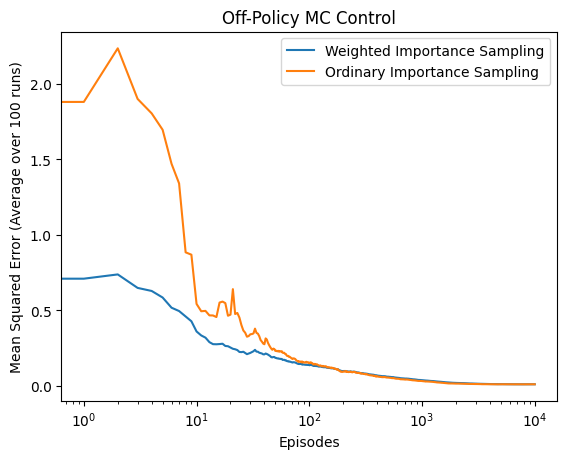

In [9]:
plt.figure()
plt.plot(avgMSE1, label='Weighted Importance Sampling')
plt.plot(avgMSE2, label='Ordinary Importance Sampling')
plt.xlabel('Episodes')
plt.ylabel('Mean Squared Error (Average over 100 runs)')

plt.xscale('log')
plt.legend()
plt.title('Off-Policy MC Control')
plt.show()

In [10]:
def TD(gamma, V, startState, alpha, N, episodes):
    stateValue = np.zeros((4, 7))
    stateValue[0] = V
    for i in range(1, N+1):
        state = startState
        while True:
            if np.random.rand() < 0.5:
                action = 1
            else:
                action = -1
            nextState = state + action
            reward = 1 if state == 5 and action == 1 else 0
            V[state] += alpha * (reward + gamma * V[nextState] - V[state])
            if nextState == 6 or nextState == 0:
                break
            state = nextState
        if i in episodes:
            stateValue[episodes.index(i)] = V
    return stateValue

V = np.full((7,), 0.5)
V[0] = 0
V[6] = 0
episodes = [0, 1, 10, 100]

stateValue = TD(1, V, 3, 0.1, 100, episodes)
V_ = np.array([0, 1/6, 2/6, 3/6, 4/6, 5/6, 0])

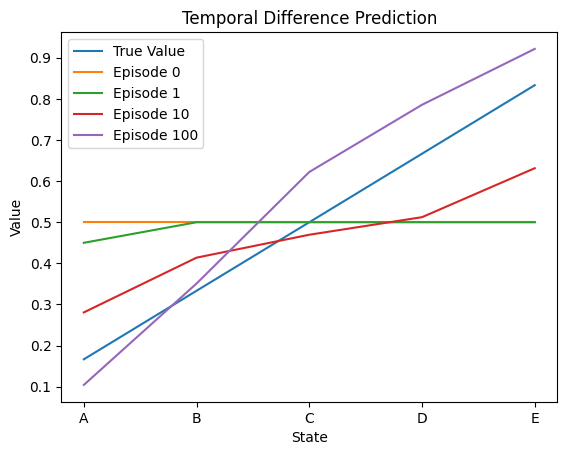

In [11]:
plt.figure()
plt.plot(V_[1:6], label='True Value')
for i, episode in enumerate(episodes):
    plt.plot(stateValue[i][1:6], label=f'Episode {episode}')
plt.xlabel('State')
plt.ylabel('Value')
plt.xticks(np.arange(5), ['A', 'B', 'C', 'D', 'E'])
plt.legend()
plt.title('Temporal Difference Prediction')
plt.show()

In [12]:
def MC_RMS(gamma, startState, alpha, epsilon, N, stateValues):
    rms = np.zeros(N)
    Q = {}
    policy = {}
    
    for state in range(1, 6):
        Q[state] = np.zeros(2)
        policy[state] = 1
    
    for i in range(N):
        state = startState
        episode = []
        
        while True:
            if np.random.rand() < epsilon:
                action = np.random.choice([1, -1])
            else:
                action = policy[state]
            
            next_state = state + action
            reward = 1 if state == 5 and action == 1 else 0
            episode.append((state, action, reward))
            if next_state == 6 or next_state == 0:
                break
            state = next_state

        G = 0
        episode.reverse()
        for state, action, reward in episode:
            G = gamma * G + reward
            index = 0 if action == 1 else 1
            if state not in Q:
                Q[state] = np.zeros(2)
            Q[state][index] += alpha * (G - Q[state][index]) 
            best_action = np.argmax(Q[state])
            policy[state] = 1 if best_action == 0 else -1

        V = np.array([0] + [np.max(Q[s]) for s in range(1, 6)] + [0])
        rms[i] = np.sqrt(np.mean(np.square(V[1:6] - stateValues[1:6])))
    
    return rms

def TD_RMS(gamma, V, startState, alpha, N, stateValues):
    rms = np.zeros(N)
    for i in range(N):
        state = startState
        while True:
            if np.random.rand() < 0.5:
                action = 1
            else:
                action = -1
            nextState = state + action
            reward = 1 if state == 5 and action == 1 else 0
            V[state] += alpha * (reward + gamma * V[nextState] - V[state])
            if nextState == 6 or nextState == 0:
                break
            state = nextState
        rms[i] = np.sqrt(np.mean(np.square(V[1:6] - stateValues[1:6])))
    return rms

In [13]:
stateValues = np.array([0, 1/6, 2/6, 3/6, 4/6, 5/6, 0])
V = np.full((7,), 0.5)
V[0] = 0
V[6] = 0

rmsTD = TD_RMS(1, V.copy(), 3, 0.05, 100, stateValues)
rmsTD_ = TD_RMS(1, V.copy(), 3, 0.10, 100, stateValues)
rmsTD__ = TD_RMS(1, V.copy(), 3, 0.15, 100, stateValues)

rmsMC = MC_RMS(1, 3, 0.01, 0.1, 100, stateValues)
rmsMC_ = MC_RMS(1, 3, 0.02, 0.1, 100, stateValues)
rmsMC__ = MC_RMS(1, 3, 0.03, 0.1, 100, stateValues)
rmsMC___ = MC_RMS(1, 3, 0.04, 0.1, 100, stateValues)

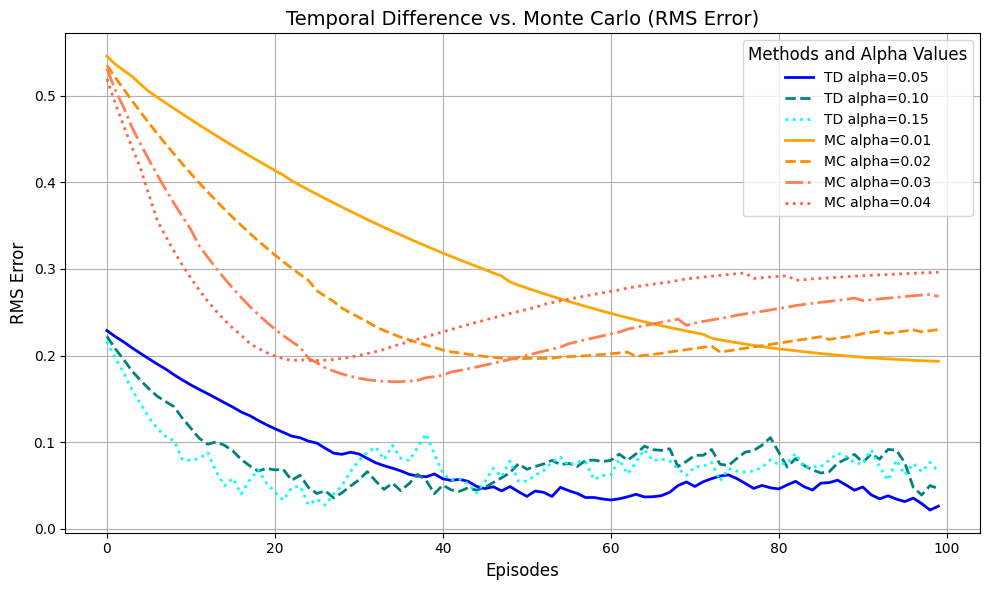

In [14]:
plt.figure(figsize=(10, 6))

plt.plot(rmsTD, label='TD alpha=0.05', color='blue', linestyle='-', lw=2)
plt.plot(rmsTD_, label='TD alpha=0.10', color='teal', linestyle='--', lw=2)
plt.plot(rmsTD__, label='TD alpha=0.15', color='cyan', linestyle=':', lw=2)

plt.plot(rmsMC, label='MC alpha=0.01', color='orange', linestyle='-', lw=2)
plt.plot(rmsMC_, label='MC alpha=0.02', color='darkorange', linestyle='--', lw=2)
plt.plot(rmsMC__, label='MC alpha=0.03', color='coral', linestyle='-.', lw=2)
plt.plot(rmsMC___, label='MC alpha=0.04', color='tomato', linestyle=':', lw=2)

plt.legend(title='Methods and Alpha Values', fontsize=10, title_fontsize=12, loc='upper right')

plt.xlabel('Episodes', fontsize=12)
plt.ylabel('RMS Error', fontsize=12)
plt.title('Temporal Difference vs. Monte Carlo (RMS Error)', fontsize=14)

plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
def epsilon_greedy_policy(state, Q, epsilon, env):
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    else:
        if state not in Q:
            Q[state] = np.zeros(env.action_space.n)
        return np.argmax(Q[state])

def SARSA(env, gamma, alpha, N, epsilon):
    Q = {}
    rewards = np.zeros(N)
    
    for i in range(N):  
        state = env.reset()[0]
        totalReward = 0
            
        action = epsilon_greedy_policy(state, Q, epsilon, env)
        
        while True:           
            nextState, reward, terminated, _, _ = env.step(action)
            totalReward += reward
            
            nextAction = epsilon_greedy_policy(nextState, Q, epsilon, env)
            
            if state not in Q:
                Q[state] = np.zeros(env.action_space.n)
            if nextState not in Q:
                Q[nextState] = np.zeros(env.action_space.n)
            
            Q[state][action] += alpha * (reward + gamma * Q[nextState][nextAction] - Q[state][action])
            
            state = nextState
            action = nextAction
            
            if terminated:
                rewards[i] = totalReward
                break

    return Q, rewards

def QLearning(env, gamma, alpha, N, epsilon):
    Q = {}
    rewards = np.zeros(N)
    
    for i in range(N):      
        state = env.reset()[0]
        totalReward = 0
        
        while True:    
            action = epsilon_greedy_policy(state, Q, epsilon, env)
            
            nextState, reward, terminated, _, _ = env.step(action)
            totalReward += reward
            
            if state not in Q:
                Q[state] = np.zeros(env.action_space.n)
            if nextState not in Q:
                Q[nextState] = np.zeros(env.action_space.n)
            
            Q[state][action] += alpha * (reward + gamma * np.max(Q[nextState]) - Q[state][action])
            
            state = nextState
            
            if terminated:
                rewards[i] = totalReward
                break

    return Q, rewards

env = gym.make('CliffWalking-v0')
episodes = 500
runs = 100
avgSarsaRewards = np.zeros(episodes)
avgQLearningRewards = np.zeros(episodes)

for _ in range(runs):
    QSarsa, rewardsSarsa = SARSA(env, 1, 0.5, episodes, 0.1)
    Q_QLearning, rewardsQLearning = QLearning(env, 1, 0.5, episodes, 0.1)
    
    avgSarsaRewards += rewardsSarsa
    avgQLearningRewards += rewardsQLearning

avgSarsaRewards /= runs
avgQLearningRewards /= runs

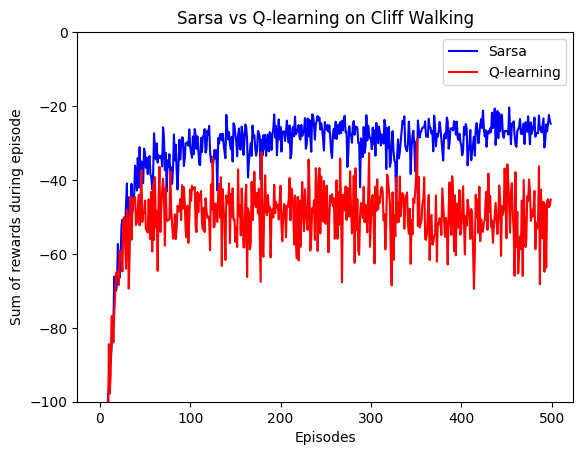

In [18]:
plt.plot(avgSarsaRewards, label="Sarsa", color="blue")
plt.plot(avgQLearningRewards, label="Q-learning", color="red")
plt.xlabel("Episodes")
plt.ylabel("Sum of rewards during episode")
plt.title("Sarsa vs Q-learning on Cliff Walking")
plt.legend()
plt.ylim([-100, 0])

plt.show()